# Survival Analysis

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Distributions", "Random", "CSV", "Plots", "DataFrames")

## The Weibull Distribution

In [2]:
using Distributions, Plots, DataFrames

In [3]:
λ = 3
k = 0.8
actual_dist = Weibull(k, λ);

In [4]:
cdf(actual_dist, 2)

0.5146966796764469

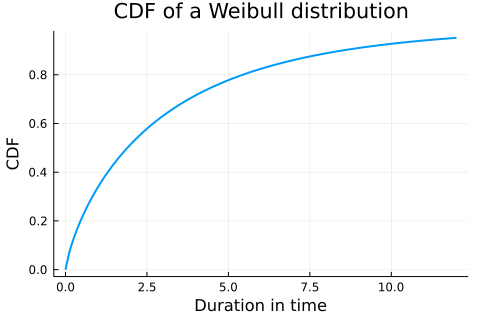

In [5]:
include("empiricaldist.jl"); using .EmpiricalDist

qs = range(0, 12, length=101)
ps = cdf.(actual_dist, qs)

c = Cdf(ps, qs)
plot(c,
     xlabel="Duration in time",
     ylabel="CDF",
     title="CDF of a Weibull distribution")

In [6]:
using Random
Random.seed!(17)

MersenneTwister(17)

In [7]:
data = rand(actual_dist, 10)

10-element Vector{Float64}:
 1.0894829985539785
 7.982754303707885
 6.782499967948609
 1.905366621856222
 5.780642629969891
 0.016299068532312215
 3.6378022244113293
 1.6232891222070238
 2.0377181363852634
 3.237661592391496

In [8]:
λs = range(0.1, 10.1, length=101)
prior_lam = makeuniform(λs, name="lambda");

In [9]:
ks = range(0.1, 5.1, length=101)
prior_k = makeuniform(ks, name="k");

In [10]:
prior = makejoint(prior_lam, prior_k);

In [11]:
likelihood = [prod(pdf.(Weibull(k, λ), data)) for k ∈ ks, λ ∈ λs];
sum(likelihood)

9.110257853854942e-8

In [12]:
posterior = prior .* likelihood
normalize!(posterior)

8.930749783212374e-12

In [13]:
"""Update the prior based on data."""
function update_weibull(prior, data)
    likelihood = [prod(pdf.(Weibull(k, λ), data)) for k ∈ prior.y, λ ∈ prior.x];
    posterior = prior .* likelihood
    normalize!(posterior)

    return posterior
end

update_weibull

In [14]:
posterior = update_weibull(prior, data);

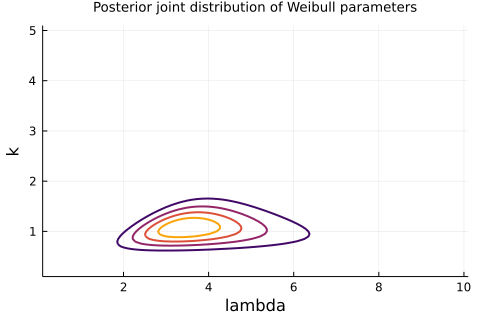

In [15]:
contour(posterior, xlabel="lambda", ylabel="k", 
    title="Posterior joint distribution of Weibull parameters", titlefontsize=9)

## Marginal Distributions

In [16]:
posterior_lam = marginal(posterior, 1)
posterior_k = marginal(posterior, 2);

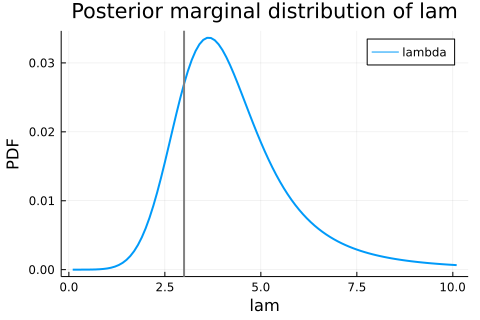

In [17]:
plot(posterior_lam, label="lambda", xlabel="lam",
         ylabel="PDF", 
         title="Posterior marginal distribution of lam")
vline!([3], color=:gray, label="")



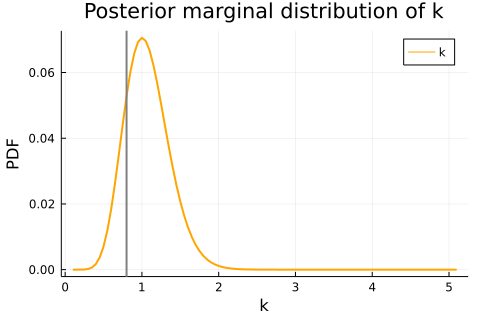

In [18]:
plot(posterior_k, label="k", xlabel="k",
         ylabel="PDF", color=:orange,
         title="Posterior marginal distribution of k")
vline!([0.8], color=:gray, label="")

In [19]:
λ, credibleinterval(posterior_lam, 0.9)

(3, [2.3, 7.1])

In [20]:
k, credibleinterval(posterior_k, 0.9)

(0.8, [0.65, 1.6])

## Incomplete Data

In [21]:
Random.seed!(19)

MersenneTwister(19)

In [22]:
start = rand(Uniform(0, 8), 10)
start

10-element Vector{Float64}:
 6.244397848743571
 1.7694732119123078
 6.321802013769794
 5.4534788631446585
 6.964540847028465
 6.521763871505341
 1.194530647874279
 0.8213646588387711
 4.863732622277386
 1.0374752547920885

In [23]:
Random.seed!(17)

MersenneTwister(17)

In [24]:
duration = rand(actual_dist, 10)
duration

10-element Vector{Float64}:
 1.0894829985539785
 7.982754303707885
 6.782499967948609
 1.905366621856222
 5.780642629969891
 0.016299068532312215
 3.6378022244113293
 1.6232891222070238
 2.0377181363852634
 3.237661592391496

In [25]:
obs = DataFrame("start"=>start, "end"=>start+duration);

In [26]:
sort!(obs)

,start,end
,Float64,Float64
1,0.821365,2.44465
2,1.03748,4.27514
3,1.19453,4.83233
4,1.76947,9.75223
5,4.86373,6.90145
6,5.45348,7.35885
7,6.2444,7.33388
8,6.3218,13.1043
9,6.52176,6.53806


In [27]:
censored = obs[!,"end"] .> 8;

In [28]:
obs[censored, "end"] .= 8
obs[!, "status"] = 1 .- censored;

In [29]:
"""Plot a line for each observation.
    
obs: DataFrame

"""
function plot_lifelines(obs)
    plot(xlabel="Time (weeks)",
            ylabel="Dog index",
            title="Lifelines showing censored and uncensored observations",
            titlefontsize=10)
    for row in eachrow(obs)
        y = rownumber(row)
        st = row["start"]
        en = row["end"]
        status = row["status"]
        
        if status == 0
            # ongoing
            plot!([st; en], [y; y], color=:blue)
        else
            # complete
            plot!([st; en], [y; y], color=:orange)
            plot!([en], [y], marker=:circle, color=:orange)
        end
    end
    plot!(yaxis=:flip)
end

plot_lifelines

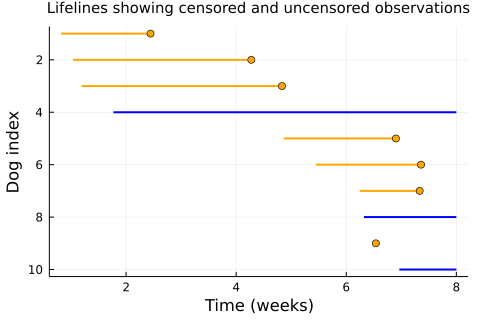

In [30]:
plot_lifelines(obs)

In [31]:
obs[!, "T"] = obs[!, "end"] .- obs[!, "start"];

## Using Incomplete Data

In [32]:
data1 = obs[.!censored, "T"]
data2 = obs[censored, "T"];

In [33]:
data1

7-element Vector{Float64}:
 1.6232891222070238
 3.237661592391496
 3.6378022244113293
 2.037718136385264
 1.9053666218562224
 1.0894829985539785
 0.016299068532312333

In [34]:
data2

3-element Vector{Float64}:
 6.230526788087692
 1.6781979862302059
 1.0354591529715353

In [35]:
posterior1 = update_weibull(prior, data1);

In [36]:
"""Update the prior using incomplete data."""
function update_weibull_incomplete(prior, data)
    likelihood = [prod(ccdf.(Weibull(k, λ), data)) for k ∈ prior.y, λ ∈ prior.x];
    posterior = prior .* likelihood
    normalize!(posterior)

    return posterior
end

update_weibull_incomplete

In [37]:
posterior2 = update_weibull_incomplete(posterior1, data2);

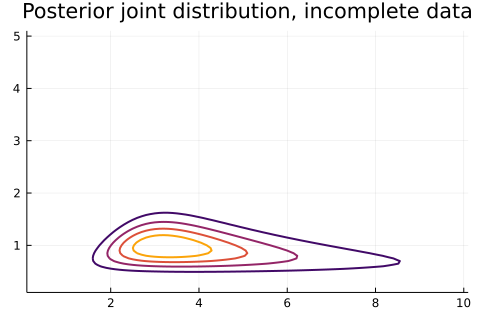

In [38]:
contour(posterior2, title="Posterior joint distribution, incomplete data")

In [39]:
posterior_lam2 = marginal(posterior2, 1)
posterior_k2 = marginal(posterior2, 2);

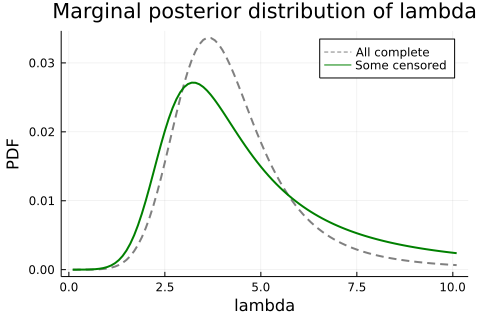

In [40]:
plot(posterior_lam, color=:gray, label="All complete",
                   linestyle=:dash)
plot!(posterior_lam2, color=:green, label="Some censored")

xlabel!("lambda")
ylabel!("PDF")
title!("Marginal posterior distribution of lambda")

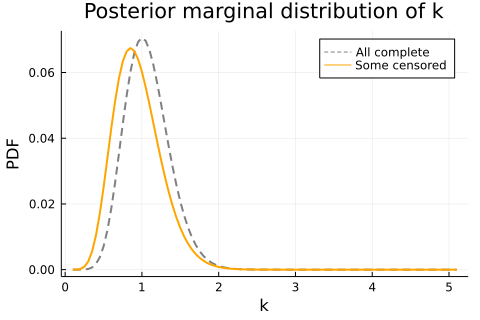

In [41]:
plot(posterior_k, color=:gray, label="All complete",
                   linestyle=:dash)
plot!(posterior_k2, color=:orange, label="Some censored")

plot!(xlabel="k",
         ylabel="PDF", 
         title="Posterior marginal distribution of k")

## Light Bulbs

In [42]:
getfile("https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv")

In [43]:
import CSV
df = CSV.File("lamps.csv") |> DataFrame;

In [44]:
pmf_bulb = Pmf(df.f, df.h)
normalize!(pmf_bulb)

50.0

In [45]:
mean(pmf_bulb)

1413.84

In [46]:
lams = range(1000, 2000, length=51)
prior_lam = makeuniform(lams, name="lambda");

In [47]:
ks = range(1, 10, length=51)
prior_k = makeuniform(ks, name="k");

In [48]:
prior_bulb = makejoint(prior_lam, prior_k);

In [49]:
data_bulb = vcat(fill.(df.h, df.f)...)
length(data_bulb)

50

In [50]:
posterior_bulb = update_weibull(prior_bulb, data_bulb);

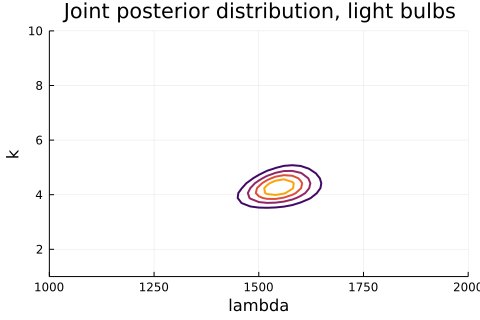

In [51]:
contour(posterior_bulb, title="Joint posterior distribution, light bulbs", xlabel="lambda", ylabel="k")

## Posterior Means

In [52]:
means = mean.(Weibull.(prior_bulb.y, prior_bulb.x'))
size(means)

(51, 51)

In [53]:
pr = posterior_bulb .* means;

In [54]:
sum(pr)

1412.7242774305005

In [55]:
"""Compute the mean of a joint distribution of Weibulls."""
function joint_weibull_mean(joint)
    means = mean.(Weibull.(joint.y, joint.x'))
    pr = joint .* means
    return sum(pr)
end

joint_weibull_mean

## Incomplete Information

In [56]:
"""Update the prior based on data."""

function update_weibull_between(prior, data, dt=12)
    dist = Weibull.(prior.y, prior.x')
    likelihood = [prod(cdf.(d, data) - cdf.(d, data .- dt)) for d in dist]
    posterior = prior .* likelihood
    normalize!(posterior)

    return posterior
end

update_weibull_between (generic function with 2 methods)

In [57]:
posterior_bulb2 = update_weibull_between(prior_bulb, data_bulb);

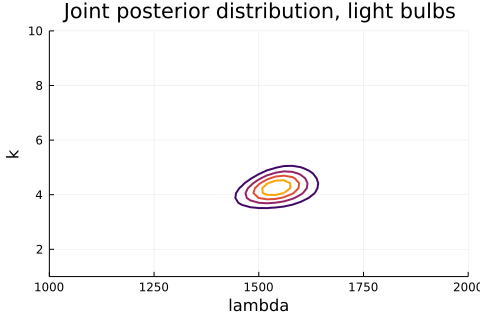

In [58]:
contour(posterior_bulb2, title="Joint posterior distribution, light bulbs", xlabel="lambda", ylabel="k")

In [59]:
joint_weibull_mean(posterior_bulb)

1412.7242774305005

In [60]:
joint_weibull_mean(posterior_bulb2)

1406.8171982320873

## Posterior Predictive Distribution

In [61]:
lam = 1550
k = 4.25
t = 1000

prob_dead = cdf(Weibull(k, lam), t)
prob_dead

0.14381685899960547

In [62]:
n = 100
p = prob_dead
dist_num_dead = makebinomial(n, p);

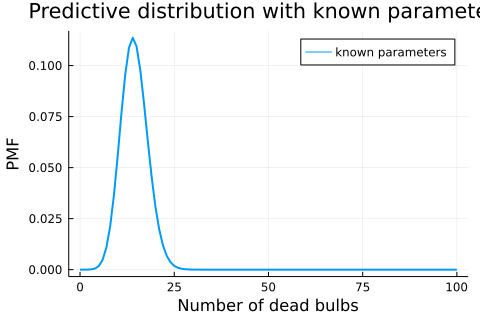

In [63]:
plot(dist_num_dead, label="known parameters",
    xlabel="Number of dead bulbs", ylabel="PMF",
    title="Predictive distribution with known parameters")

In [64]:
posterior_series = stack(posterior_bulb);
first(posterior_series, 5)

┌───────────────┬─────────────┐
│               │       probs │
├───────────────┼─────────────┤
│ (1.0, 1000.0) │ 8.14676e-25 │
│ (1.0, 1020.0) │ 1.21049e-24 │
│ (1.0, 1040.0) │ 1.73833e-24 │
│ (1.0, 1060.0) │  2.4182e-24 │
│ (1.0, 1080.0) │ 3.26555e-24 │
└───────────────┴─────────────┘


In [65]:
pmf_seq = Pmf{Float64, Int64}[]
for (k, lam) in keys(posterior_series)
    prob_dead = cdf(Weibull(k, lam), t)
    pmf = makebinomial(n, prob_dead)
    push!(pmf_seq, pmf)
end

In [66]:
post_pred = makemixture(posterior_series, pmf_seq);

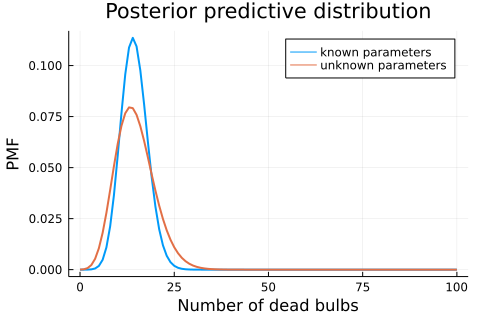

In [67]:
plot(dist_num_dead, label="known parameters")
plot!(post_pred, label="unknown parameters",
      xlabel="Number of dead bulbs", ylabel="PMF",
         title="Posterior predictive distribution")

## Summary

## Exercises

In [68]:
# Solution

t = 1000

prob_dead = cdf.(Weibull.(prior_bulb.y, prior_bulb.x'), t)
size(prob_dead)

(51, 51)

In [69]:
# Solution

k = 20
n = 100
likelihood = pdf.(Binomial.(n, prob_dead), k)
size(likelihood)

(51, 51)

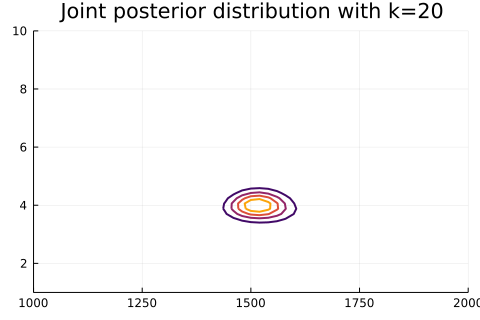

In [70]:
# Solution

posterior_bulb3 = posterior_bulb .* likelihood
normalize!(posterior_bulb3)
contour(posterior_bulb3,
         title="Joint posterior distribution with k=20")

In [71]:
# Solution

# Since there were more dead bulbs than expected,
# the posterior mean is a bit less after the update.

joint_weibull_mean(posterior_bulb3)

1378.3949572816412

In [72]:
# Load the data file

getfile("https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2203951.csv")

In [73]:
weather = CSV.File("2203951.csv") |> DataFrame
first(weather, 5)

,STATION,NAME,DATE,AWND,PRCP,TMAX
,String,String,Date…,Float64?,Float64,Int64
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-01,4.47,0.0,66
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-02,9.4,0.24,58
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-03,11.63,0.06,57
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-04,4.47,0.0,65
5,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-05,7.83,0.0,71


In [74]:
rained = weather.PRCP .> 0
sum(rained)

14

In [75]:
prcp = weather[rained, "PRCP"]
describe(prcp)

Summary Stats:
Length:         14
Missing Count:  0
Mean:           0.222857
Minimum:        0.010000
1st Quartile:   0.052500
Median:         0.110000
3rd Quartile:   0.225000
Maximum:        1.140000
Type:           Float64


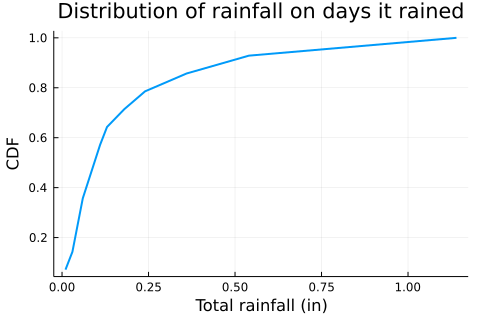

In [76]:
cdf_data = cdffromseq(prcp)
plot(cdf_data,
         xlabel="Total rainfall (in)",
         ylabel="CDF",
         title="Distribution of rainfall on days it rained")

In [77]:
# Solution

# I'll use the MLE parameters of the gamma distribution
# to help me choose priors

fit_dist = fit(Gamma, prcp)
k_est, θ_est = fit_dist.α, fit_dist.θ

(0.889887601752528, 0.25043291132301676)

In [78]:
# Solution

# I'll use uniform priors for the parameters.
# I chose the upper bounds by trial and error.

ks = range(0.01, 2, length=51)
prior_k = makeuniform(ks, name="k");

In [79]:
# Solution

θs = range(0.01, 1.5, length=51)
prior_theta = makeuniform(θs, name="theta");

In [80]:
# Solution

# Here's the joint prior

prior = makejoint(prior_k, prior_theta);

In [81]:
# Solution

# we'll compute likelihood in one go

likelihood = [prod(pdf.(Gamma(k, θ), prcp)) for θ ∈ rows(prior), k ∈ columns(prior)]
size(likelihood)

(51, 51)

In [82]:
sum(likelihood)

150287.9198013646

In [83]:
# Solution

# Now we can do the update in the usual way

posterior = prior .* likelihood
normalize!(posterior)

57.780822684107875

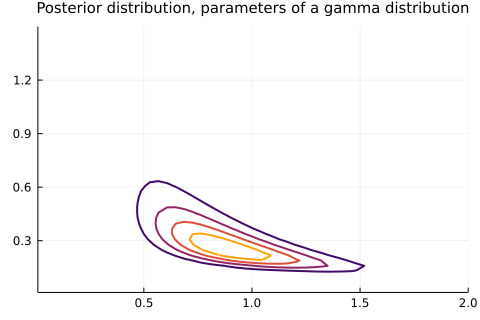

In [84]:
# Solution

# And here's what the posterior looks like

contour(posterior,
        title="Posterior distribution, parameters of a gamma distribution",
        titlefontsize=10)

In [85]:
# Solution

# I'll check the marginal distributions to make sure the
# range of the priors is wide enough

posterior_k = marginal(posterior, 1)
posterior_theta = marginal(posterior, 2);

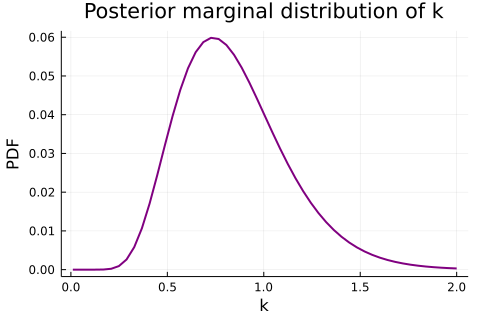

In [86]:
# Solution

# The marginal distribution for k is close to 0 at both ends

plot(posterior_k, color=:purple, 
         xlabel="k",
         ylabel="PDF", 
         title="Posterior marginal distribution of k")

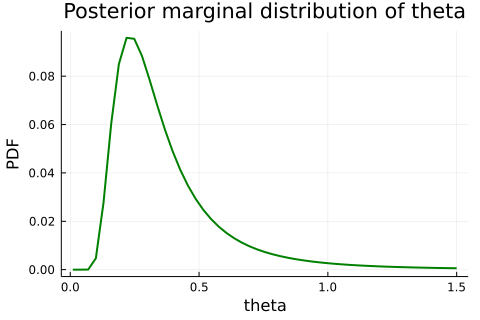

In [87]:
# Solution

# Same with the marginal distribution of theta

plot(posterior_theta, color=:green,
         xlabel="theta",
         ylabel="PDF", 
         title="Posterior marginal distribution of theta")

In [88]:
# Solution

mean(posterior_theta), credibleinterval(posterior_theta, 0.9)

(0.36776130746038305, [0.159, 0.7848])

In [89]:
# Solution

# To compute the posterior predictive distribution,
# I'll stack the joint posterior to make a Series
# with a MultiIndex

posterior_series = stack(posterior)
first(posterior_series, 5)

┌────────────────┬──────────────┐
│                │        probs │
├────────────────┼──────────────┤
│   (0.01, 0.01) │ 4.30626e-156 │
│ (0.01, 0.0498) │ 1.30407e-145 │
│ (0.01, 0.0896) │ 2.46389e-141 │
│ (0.01, 0.1294) │ 2.07783e-138 │
│ (0.01, 0.1692) │ 4.22722e-136 │
└────────────────┴──────────────┘


In [90]:
# Solution

# I'll extend the predictive distribution up to 2 inches

low, high = 0.01, 2

(0.01, 2)

In [91]:
# Solution

# Now we can iterate through `posterior_series`
# and make a sequence of predictive Pmfs, one
# for each possible pair of parameters

qs = range(low, high, length=101)
pmf_seq = Pmf{Float64, Float64}[]
for (θ, k) in keys(posterior_series)
    dist = Gamma(k, θ)
    pmf = pmffromdist(dist, qs)
    push!(pmf_seq, pmf)
end

In [92]:
# Solution

# And we can use `make_mixture` to make the posterior predictive
# distribution

post_pred = makemixture(posterior_series, pmf_seq);

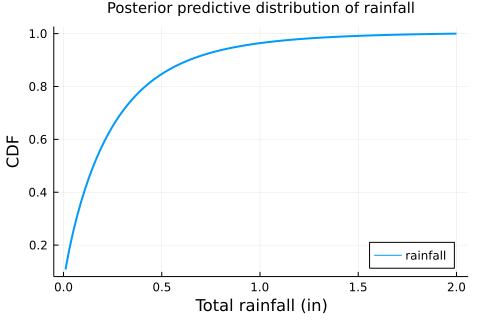

In [93]:
# Solution

# Here's what it looks like.

plot(makecdf(post_pred), label="rainfall",
     xlabel="Total rainfall (in)",
         ylabel="CDF", legend=:bottomright, titlefontsize=10, 
         title="Posterior predictive distribution of rainfall")

In [94]:
# Solution 

# The probability of more than 1.5 inches of rain is small

c = makecdf(post_pred)
p_gt = 1 .- c(1.5)
p_gt

0.008506610933203929

In [95]:
# Solution 

# So it's easier to interpret as the number of rainy
# days between events, on average

1 ./ p_gt

117.55562912801047